# Introduction
-------------------------------------------------------------------
Данный файл содержит анализ истории сообщений чата telegram-канала https://t.me/aimylogic.
Были исследованы:
- самые активные пользователи чата;
- активность пользователей в разные годы, разные месяцы, разные дни, разное время дня;
- часто упоминаемые ссылки, хэштеги и другое
- часто встречающиеся слова
- различного рода статистики

Ниже приведены результаты исследования и еще ниже - соответствующий код.

# Report
-------------------------------------------------------------------
История чата охватывает период с 2018 по 2023 гг. 

Как показывают расчеты, большинство пользователей (примерно 97%) проявляют свою активность **не более 50 раз** (то есть отправляют не более 50 сообщений). Несмотря на это, есть ряд пользователей, которые регулярно проявляют активность. Информация о них представлена на графиках ниже.
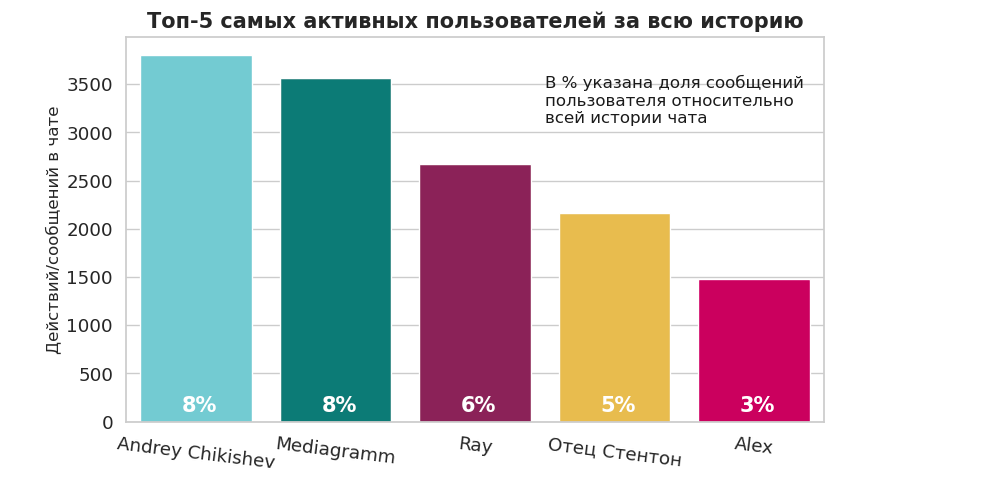
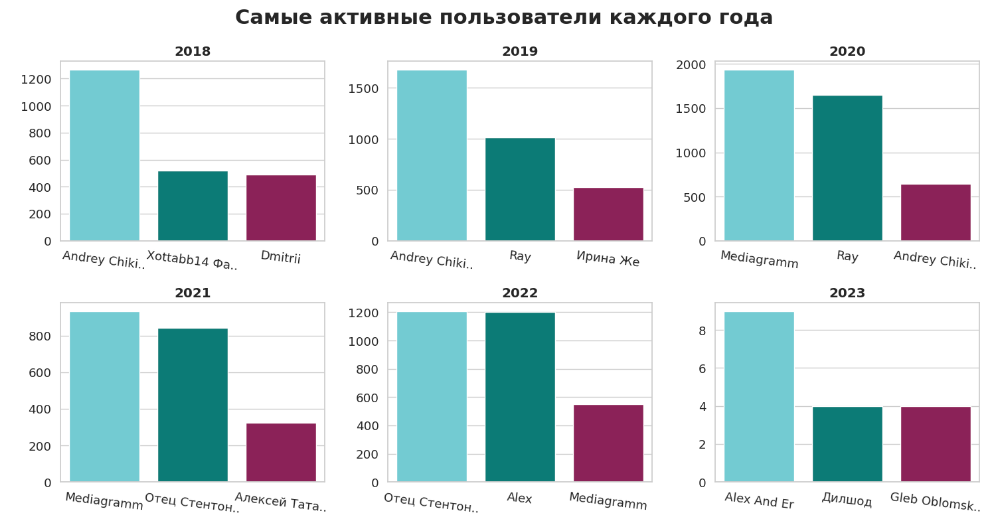
- Логично предположить, что самыми активными пользователями являются модераторы канала или непосредственно служба поддержки. Однако это не отрицает возможности присутствия в канале активных "простых" пользователей и участников

-------------------------------------------------------------------
На графиках ниже можно увидеть распределение количества сообщений/действий (приглашение/удаление участников) пользователей по каждому году и каждому месяцу.
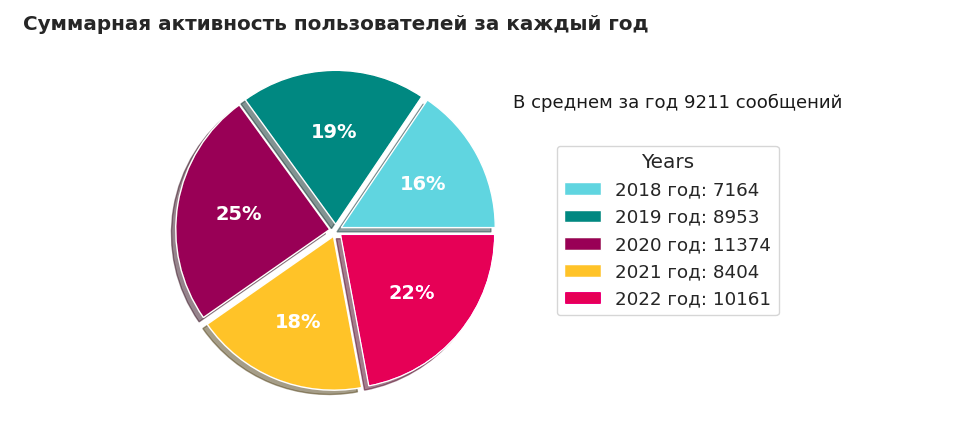
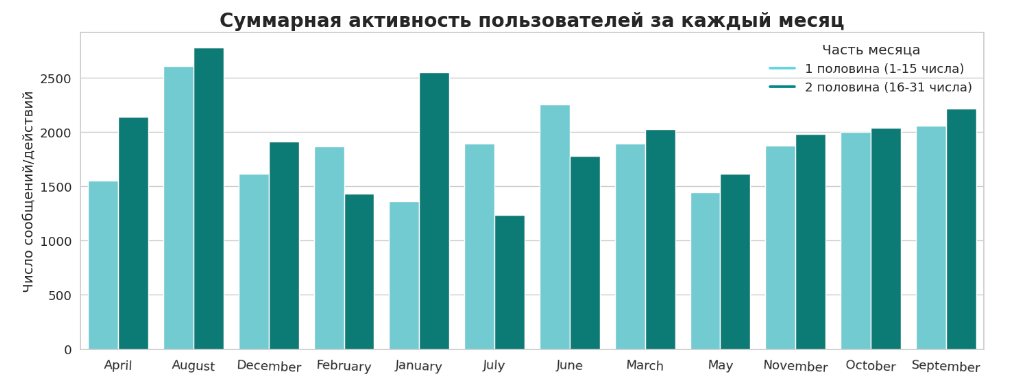
- Наибольшее число сообщений накоплено в **2020 году**
- Среди месяцев выделяется **август** по аналогичной статистике (наиболее число сообщений)
- Можно заметить сильный разрыв между числом сообщений в первой и второй половинах января. Объясняется это новогодними праздниками, на которых люди все же предпочитают отдохнуть, а вливаются в свой рабочий ритм уже позже :)

Далее рассмотрим усредненные и медианные показатели активности пользователей. Они могут дать представление о том, *когда следует быть наготове и ожидать большого числа вопросов/просьб в чате*
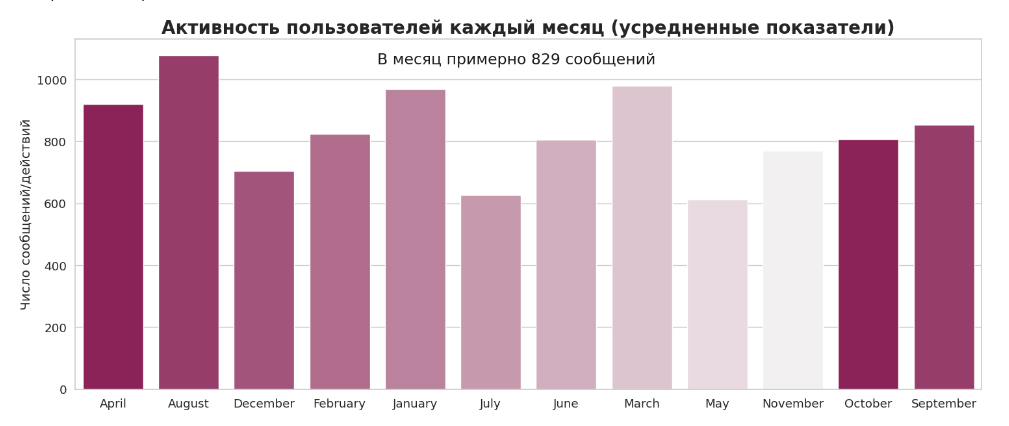
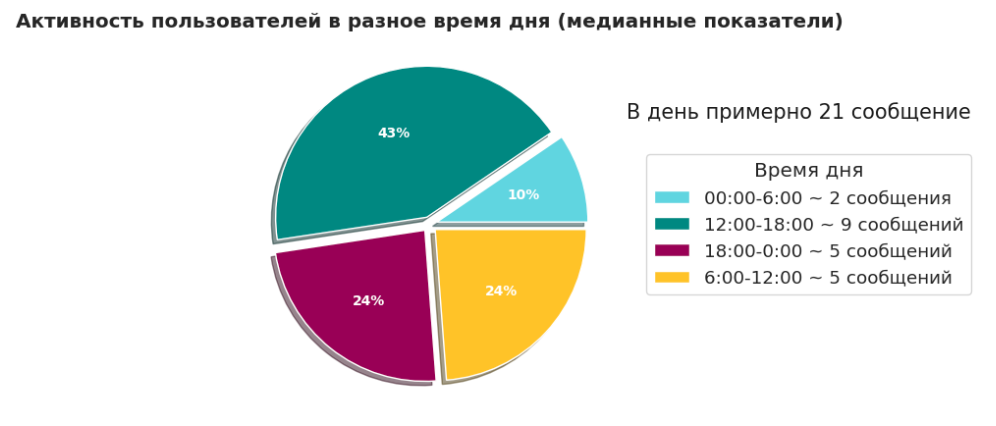
- Наивысший уровень активности достигается в том же **августе**
- В течение дня самым активным периодом является время с **12:00 до 18:00**
-------------------------------------------------------------------
В канале достаточно часто можно встретить ссылки, хэштеги, кусочки кода и другое.
Чаще остальных упоминаются **email'ы**:
* contact@aimylogic.com
* partners@aimylogic.com
* smmstudio@mediagramm.com

Наиболее частые **хэштеги**:
* #support
* #help
* #best_practice 

И, наконец, чаще всего в чате упоминаются следующие **личности/каналы**:
* @ondreychikishev
* @andreienz
* @raytelegram
-------------------------------------------------------------------
Каждое сообщение содержит примерно **8 слов**, а каждое слово состоит в среднем из **5 символов**. Ниже приведен график распределения числа слов в сообщении
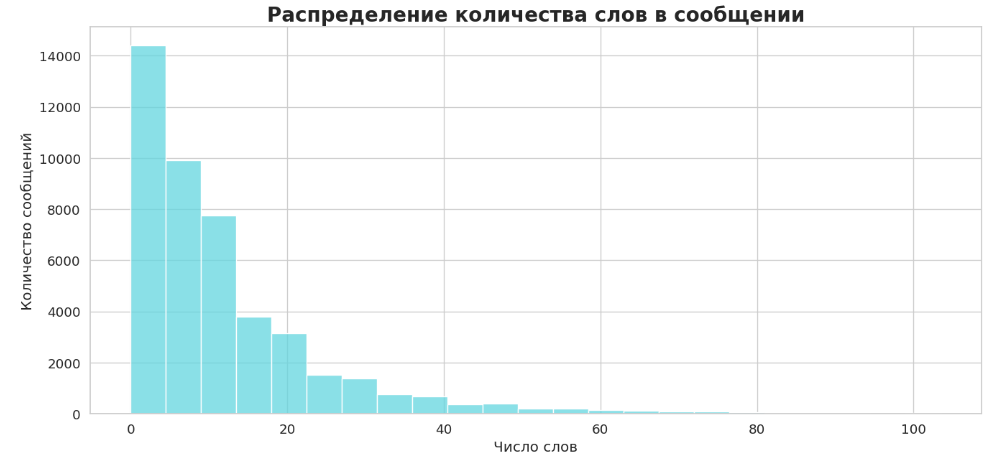
- Большинство сообщений короткие по длине (что не удивительно, т.к. чат не является деловым)

-------------------------------------------------------------------
Для имеющегося набора текстов сообщений было построено **облако слов**, которое позволяет грубо оценить характер общения в чате
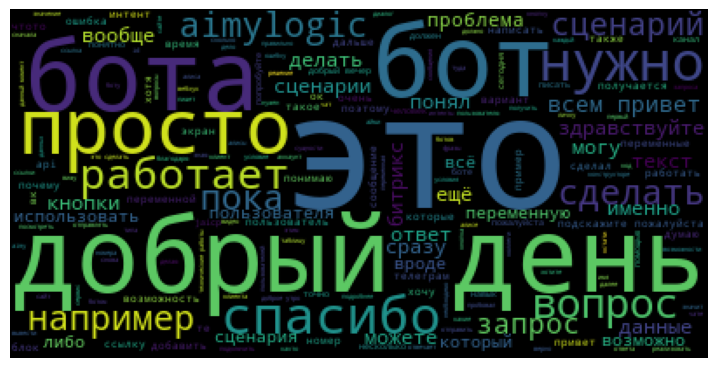
- Набор наиболее часто встречающихся слов вполне соответствует одной из главных задач канала - поддержке пользователей по сервису **Aimylogic**

-------------------------------------------------------------------
Дополнительную информацию/графики можно увидеть непосредственно в коде.

# table of contents
-------------------------------------------------------------------
* [Библиотеки и функции](#libs)
* [Загрузка данных](#loading)
* [Анализ](#main)
    * [Пользователи](#1)
    * [Активность](#2)
    * [Содержимое сообщений](#3)
    * [Статистики по сообщениям](#4)
    * [Частотный анализ](#5)


# Libraries & Help functions <a class="anchor" id="libs"></a>

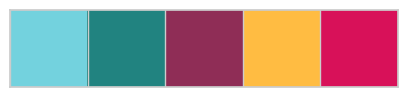

In [42]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
np.random.seed(0)
import json

import emoji
import string
from nltk import word_tokenize, Text, FreqDist
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud


# visualize
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (9, 5)
import seaborn as sns
sns.set_theme(style='whitegrid')
sns.set_context("notebook", font_scale=1.2)
custom_colors = ['#73D2DE', '#218380', '#8F2D56', '#FFBC42', '#D81159']
custom_pal = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors), size=1)

In [85]:
def json_to_pandas(file_path):
    '''convert telegram chat history to pandas.DataFrame for future analysis
    
    
    We will work with following features:
        - id: message/action identifier
        - user_id: user identifier 
        - user_name: user nickname in the Telegram
        - type: what type of action: is it service's action or user's message
        - year: the year when the action was done
        - month: the month when the action was done
        - time_month: ['1st half' (1-15 days of month), '2nd half' (16-31)]
                      the part of month when the action was done
        - time_day: ['6:00-10:00', '10:00-14:00', '14:00-18:00', '18:00-22:00', '22:00-2:00', '2:00-6:00']
                     the time of day when the action was done
        - content: message's text or service's action
        - with_file: the message may contain files/photos (binary feature)
    
    Also we will work with different message entities (hashtag, links, code, plain text, etc.)
    '''
    
    with open(file_path, 'r') as json_file:
        data = json.load(json_file)
    chat_history_data = data['messages']
    dict_data = {'id': [], 'user_id': [], 'user_name': [], 'type': [],
                 'year': [], 'month': [], 'day':[], 'time_month': [], 'time_day': [],
                 'content': [], 'with_file': []}
    month_dict = {'01':'January', '02':'February', '03':'March',
                  '04':'April', '05':'May', '06':'June', '07':'July',
                  '08':'August', '09':'September', '10':'October',
                  '11': 'November', '12':'December'}
    
    def func_time_day_match(time_hour):
        '''convert time of day'''
        result = None
        if (time_hour >= 6) and (time_hour < 12):
            result = '6:00-12:00'
        elif (time_hour >= 12) and (time_hour < 18):
            result = '12:00-18:00'
        elif (time_hour >= 18) and (time_hour < 24):
            result = '18:00-00:00'
        else:
            result = '00:00-6:00'
        return result
    
    # for independent analysis
    messages_dict = {'type': [], 'content': []}
    
    
    for obj in chat_history_data:
        # constant information
        dict_data['id'].append(obj['id'])
        dict_data['type'].append(obj['type'])
        
        # work with date
        date = obj['date']
        dict_data['year'].append(int(date[0:4]))
        dict_data['month'].append(month_dict[date[5:7]])
        dict_data['day'].append(int(date[8:10]))
        time_month = '1st half' if int(date[8:10]) < 16 else '2nd half'
        time_day = func_time_day_match(int(date[11:13]))
        dict_data['time_month'].append(time_month)
        dict_data['time_day'].append(time_day)
        
        # content and is_file
        if obj['type'] == 'message':
            entities = obj['text_entities']
            content = ''
            for entity in entities:
                #if entity['type'] in ['bold', 'plain', 'strikethrough', "text_link", 'italic']:
                content += f'{entity["text"]} '
                        
                messages_dict['type'].append(entity['type'])
                messages_dict['content'].append(entity['text'])
                
        else:
            content = obj["action"]
        is_file_flag = 1 if ('file' in obj) or ('photo' in obj) else 0
        #is_reply_flag = 1 if 'reply_to_message_id' in obj else 0
        dict_data['content'].append(content)
        dict_data['with_file'].append(is_file_flag)
        
        # work with user info
        user_id = obj["from_id"] if obj['type'] == "message" else obj["actor_id"]
        user_name = obj["from"] if obj['type'] == "message" else obj["actor"]
        dict_data['user_id'].append(user_id)
        dict_data['user_name'].append(user_name)

                    
    df_data = pd.DataFrame(data=dict_data)
    df_data.set_index('id', inplace=True)
    df_data_messages = pd.DataFrame(data=messages_dict)
    return df_data, df_data_messages

# Data loading & parsing & overview <a class="anchor" id="loading"></a>

In [86]:
whole_data, message_data = json_to_pandas(file_path='data/aimylogic(users).json')

In [314]:
whole_data.head(5)

,user_id,user_name,type,year,month,day,time_month,time_day,content,with_file
id,,,,,,,,,,
1,channel1220283619,Aimylogic (сообщество пользователей),service,2018,May,25,2nd half,18:00-00:00,migrate_from_group,0
2,user499559667,Boris Shabalin,message,2018,May,25,2nd half,18:00-00:00,Хелло,0
3,user351591662,Екатерина,message,2018,May,25,2nd half,18:00-00:00,,1
4,user351591662,Екатерина,message,2018,May,25,2nd half,18:00-00:00,"Прикиньте, даже на телефоне сервис работает",0
5,user351591662,Екатерина,message,2018,May,25,2nd half,18:00-00:00,,1


In [89]:
message_data.sample(5)

,type,content
27806,plain,понятно. приходится вместо текста ставить точк...
34895,link,https://help.aimylogic.com/#/docs/ru/smart_cal...
43143,plain,"Я писала, они ничего так и не решили"
47417,plain,"не ошибка, а сбрасываются старые звонки, когда..."
42617,plain,"Спасибо, подкорректировал и отправил 🤝✊"


In [91]:
print(f'Всего действий в чате: {len(whole_data)}')
print(f'Данные за период: {whole_data.year.min()}-{whole_data.year.max()} года')

Всего действий в чате: 46091
Данные за период: 2018-2023 года


# Analytics <a class="anchor" id="main"></a>

## 1. User activity <a class="anchor" id="1"></a>

In [92]:
user_activity = whole_data.groupby(["user_id", 'user_name']).aggregate({'year':'count'}).reset_index() \
                          .rename(columns={'year':'actions_count'}) \
                          .sort_values(by='actions_count', ascending=False)
user_activity.head(10)

,user_id,user_name,actions_count
1905,user431142189,Andrey Chikishev,3804
2379,user548664418,Mediagramm,3560
616,user163523560,Ray,2667
855,user190521897,Отец Стентон,2159
1596,user349278159,Alex,1478
222,user119585567,Xottabb14 Факел_ПСО_Запад,951
3088,user95457687,Eugene Khrustalev,816
2965,user876082035,ILYA,672
1019,user208145669,Дмитрий Савченко,659
837,user18893059,Dmitrii,627


In [93]:
# distribution of user activity
bins_custom = pd.IntervalIndex.from_tuples([(0, 50), (50, 500), (500, 3804)])
user_activity_distribution = pd.cut(user_activity['actions_count'], bins=bins_custom).value_counts()
user_activity_distribution

(0, 50]        3035
(50, 500]        95
(500, 3804]      12
Name: actions_count, dtype: int64

[Text(0, 0, '(0, 50]'), Text(1, 0, '(50, 500]'), Text(2, 0, '(500, 3804]')]

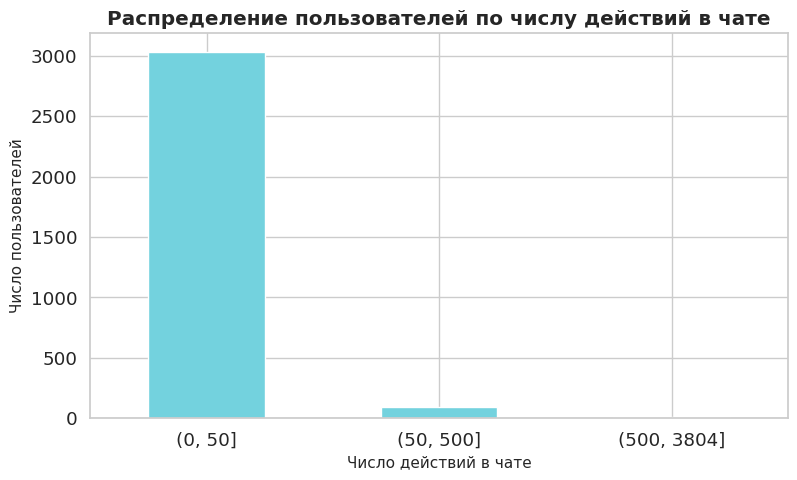

In [94]:
ax = user_activity_distribution.plot.bar()
plt.title('Распределение пользователей по числу действий в чате', fontweight='bold')
plt.xlabel('Число действий в чате', fontsize=11)
plt.ylabel('Число пользователей', fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-0)

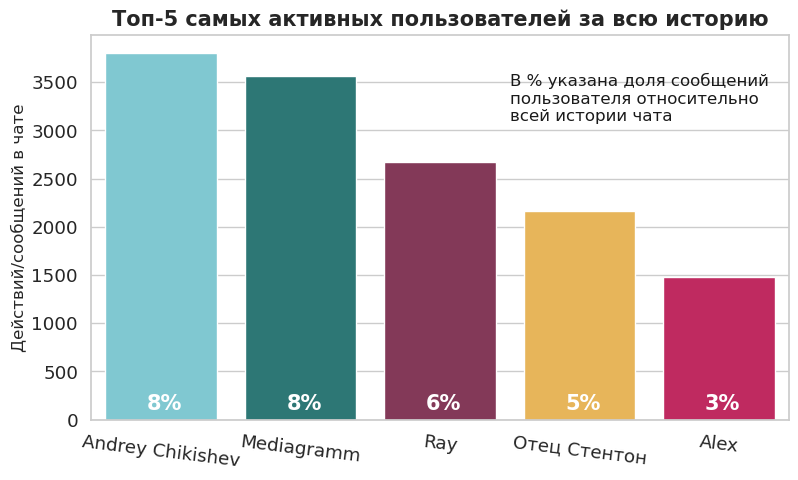

In [121]:
# most active users
top_five_users = user_activity[:5]
top_five_users['actions_ratio'] = round(top_five_users['actions_count'] / len(whole_data), 2) * 100
ax = sns.barplot(data=top_five_users, y='actions_count', x='user_name')
for bi, b in enumerate(ax.patches):
            plt.text(b.get_x() + 0.30, b.get_y() + 105.5,
                     str(round(top_five_users.iloc[bi]['actions_ratio'])) + '%',
                     fontsize=15,
                     color='w',
                     fontweight='extra bold')
plt.text(2.50, 3100,
         'В % указана доля сообщений\nпользователя относительно\nвсей истории чата',
         fontsize=12,
         color='k',)
plt.title('Топ-5 самых активных пользователей за всю историю', fontsize=15, fontweight='bold')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-7)
plt.ylabel('Действий/сообщений в чате', fontsize=12)
plt.xlabel(None)
plt.show()

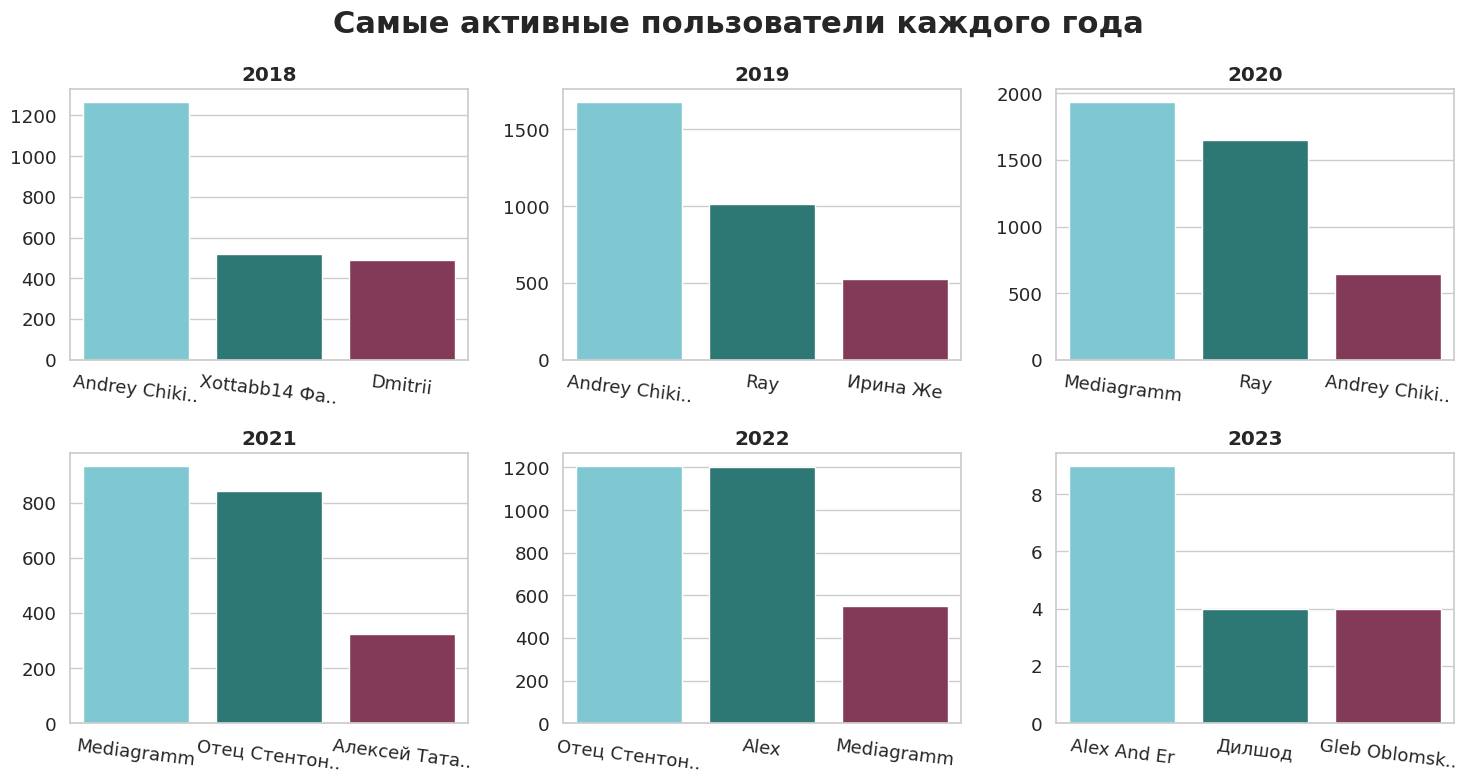

In [154]:
# most active users by each year
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for i, year in enumerate(whole_data.year.unique()):
    year_user_activity = whole_data[whole_data.year==year].groupby(["user_id", 'user_name']) \
                                                          .aggregate({'month':'count'}) \
                                                          .reset_index() \
                                                          .rename(columns={'month':'actions_count'}) \
                                                          .sort_values(by='actions_count', ascending=False)
    top_users = year_user_activity[:3]
    top_users.user_name = top_users.user_name.apply(lambda name: name if len(name) < 12 else name[:12]+"..")
    row = 1 if i>=3 else 0
    col = i if row==0 else i-3
    ax = sns.barplot(data=top_users, y='actions_count', x='user_name', ax=axs[row][col])
    ax.set_title(f'{year}', fontdict={'fontweight':'bold'})
    ax.set_ylabel(None)
    ax.set_xlabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-7, fontdict={'size':13})
plt.suptitle('Самые активные пользователи каждого года', fontsize=22, fontweight='bold')    
plt.tight_layout()
    #print(year_user_activity[:3][['user_name', 'actions_count']], end='\n\n\n')

In [155]:
# the ratio of messages and service activities
round(whole_data['type'].value_counts() / len(whole_data), 2)

message    0.92
service    0.08
Name: type, dtype: float64

In [156]:
# Which user was most often engaged in service activities? (invite members, ..)
whole_data[whole_data['type']=='service'].groupby(['user_id', 'user_name'])['year'] \
                                         .count().sort_values(ascending=False)[:5]

user_id        user_name       
user208145669  Дмитрий Савченко    13
user186387865  Julia Ryzhikh       13
user431142189  Andrey Chikishev     9
user64472064   Yulia Lemekhova      6
user796388146  Nursultan R          6
Name: year, dtype: int64

## 2. Time-frequency <a class="anchor" id="2"></a>

In [157]:
# Distribution of acitivity by year
year_distribution = whole_data.groupby('year')['month'].count() \
                              .reset_index().rename(columns={"month":"count"})
year_distribution = year_distribution.iloc[:5].set_index('year')
year_distribution

,count
year,
2018,7164
2019,8953
2020,11374
2021,8404
2022,10161


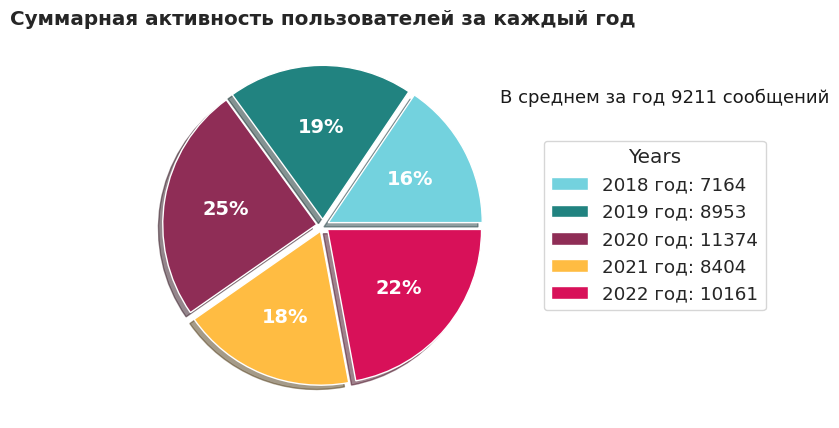

In [284]:
year_distribution.plot.pie(y='count', explode=[0.04 for i in range(5)], autopct="%1.0f%%", shadow=True,
                           legend=False, ylabel="", labels=None, 
                           textprops={'fontsize':14, 'color':'white', 'fontweight':'bold'})
mean_actions_per_year = round(year_distribution['count'].mean())
counts = year_distribution['count'].values
plt.title('Суммарная активность пользователей за каждый год', fontweight='bold')
plt.text(1.15, 0.8,
         'В среднем за год {} сообщений'.format(mean_actions_per_year),
          fontsize=13,
          color='k')
plt.legend(labels=['2018 год:' + f' {counts[0]}',
                   '2019 год:' + f' {counts[1]} ',
                   '2020 год:' + f' {counts[2]}',
                   '2021 год:' + f' {counts[3]}',
                   '2022 год:' + f' {counts[4]}'],
           loc="center left", bbox_to_anchor=(1.05, 0, 0.5, 1), title='Years')

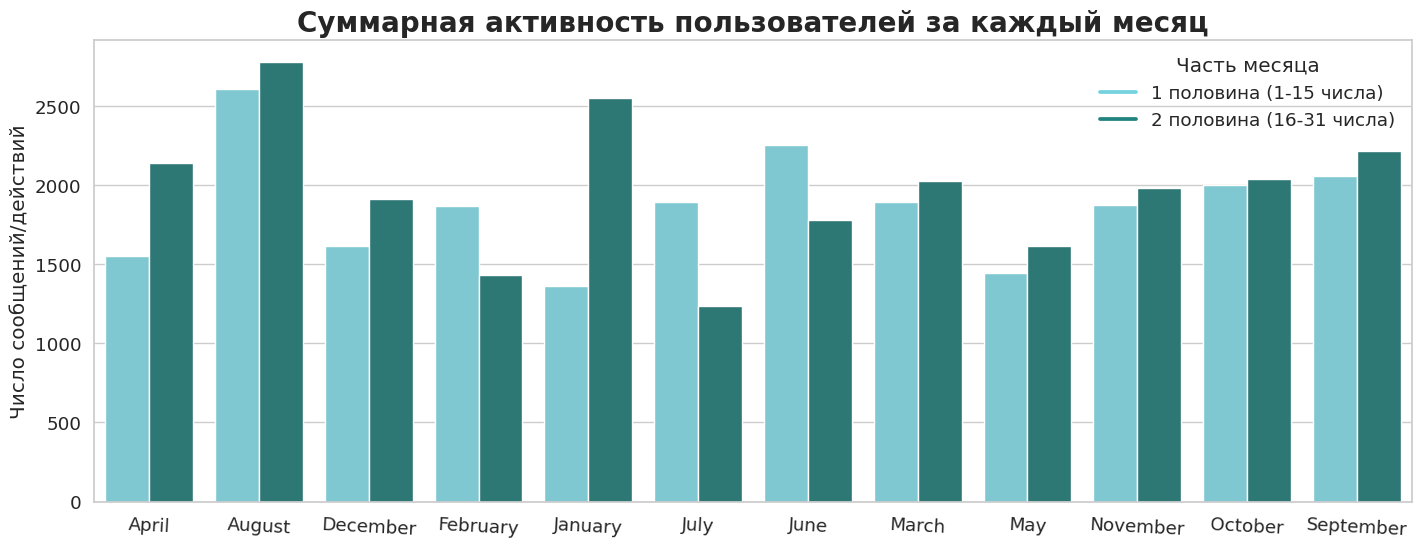

In [283]:
# Distribution of activity by time of each month (all time)
plt.figure(figsize=(17, 6))
month_time_distribution = whole_data.groupby(['month', 'time_month']).agg({"content":"count"}).reset_index() \
                                    .rename(columns={'content':'count'})
ax = sns.barplot(data=month_time_distribution,
                 x='month', y='count', hue='time_month')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-3)
plt.title(f'Суммарная активность пользователей за каждый месяц', fontsize=20, fontweight='bold')
leg = plt.legend(title='Часть месяца', loc='upper right',
                 labels=['1 половина (1-15 числа)', '2 половина (16-31 числа)'], frameon=False)
leg.legendHandles[0].set_color('#73D2DE')
leg.legendHandles[1].set_color('#218380')
plt.ylabel('Число сообщений/действий')
plt.xlabel(None)
plt.show()

Text(0.5, 0, '')

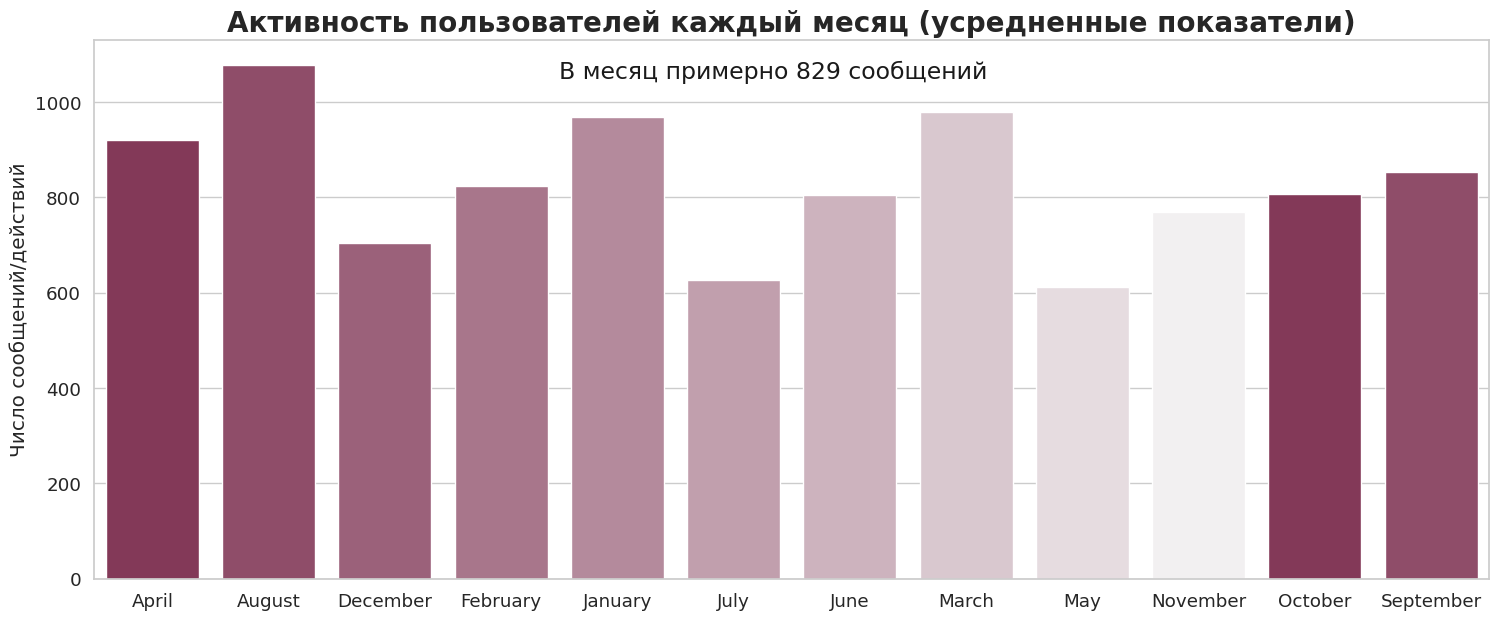

In [376]:
month_activity = whole_data[whole_data.year < 2023].groupby(['year', 'month']) \
                                                   .agg({'content':'count'}).reset_index() \
                                                   .rename(columns={'content':'count'}) 
month_mean_activity = month_activity.groupby('month').agg({'count':'mean'}).reset_index() \
                                    .rename(columns={'count':'mean'})
month_mean_activity['mean'] = round(month_mean_activity['mean']).apply(int)
plt.figure(figsize=(18, 7))
sns.barplot(data=month_mean_activity,
            x='month',
            y='mean',
            palette=sns.light_palette('#8F2D56', reverse=True, n_colors=10))
plt.title(f'Активность пользователей каждый месяц (усредненные показатели)', fontsize=20, fontweight='bold')
plt.text(3.5, 1050,
         'В месяц примерно {} сообщений'.format(round(month_mean_activity['mean'].mean())),
         fontsize=17,
         color='k')
plt.ylabel('Число сообщений/действий')
plt.xlabel(None)

In [325]:
# Distribution of activity by time of day
time_day_distribution = whole_data.groupby('time_day').agg({'content':'count'}).reset_index() \
                                  .rename(columns={'content':'count'})
time_day_distribution

,time_day,count
0,00:00-6:00,2079
1,12:00-18:00,21813
2,18:00-00:00,11487
3,6:00-12:00,10712


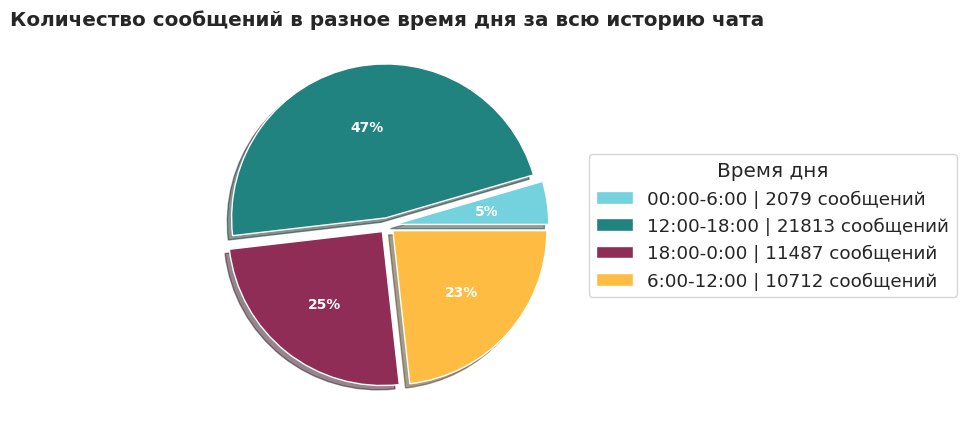

In [328]:
time_day_distribution.plot.pie(y='count', explode=[0.05 for i in range(4)], autopct="%1.0f%%", shadow=True,
                               legend=False, ylabel="", labels=None,
                               textprops={'fontsize':10, 'color':'white', 'fontweight':'bold'})
plt.title('Количество сообщений в разное время дня за всю историю чата', fontweight='bold')
plt.legend(labels=['00:00-6:00 | {} сообщений'.format(time_day_distribution.iloc[0]['count']),
                   '12:00-18:00 | {} сообщений'.format(time_day_distribution.iloc[1]['count']),
                   '18:00-0:00 | {} сообщений'.format(time_day_distribution.iloc[2]['count']),
                   '6:00-12:00 | {} сообщений'.format(time_day_distribution.iloc[3]['count'])], loc="center left",
           bbox_to_anchor=(1.0, 0, 0.5, 1), title='Время дня')
plt.show()

In [356]:
# Average activity by time of day
day_activity = whole_data[whole_data.year<2023].groupby(['year', 'month', 'day', 'time_day']) \
                                                    .agg({'content':'count'}) \
                                                    .reset_index() \
                                                    .rename(columns={'content':'count'})
day_activity = day_activity.groupby('time_day').agg({'count':'median'}) \
                           .reset_index().rename(columns={'count':'median'})
day_activity['median'] = day_activity['median'].apply(int)
median_day_activity = int(day_activity['median'].sum())

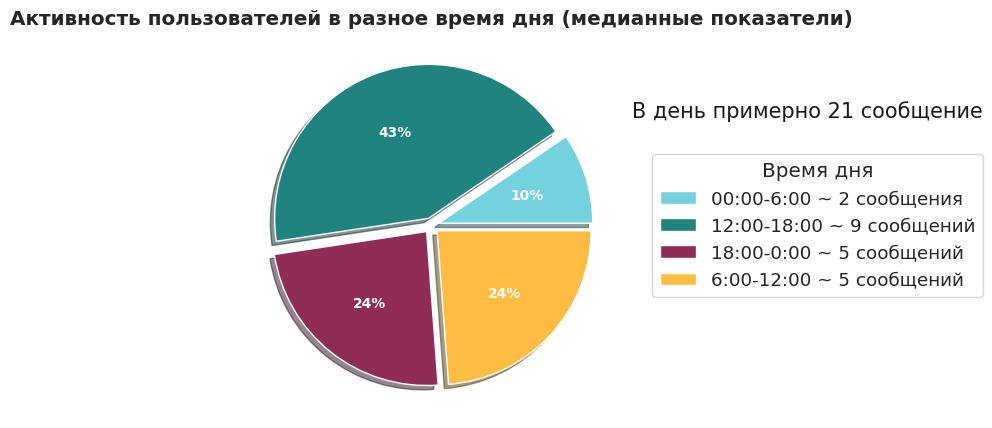

In [362]:
day_activity.plot.pie(y='median',explode=[0.05 for i in range(4)], autopct="%1.0f%%", shadow=True,
                      legend=False, ylabel="", labels=None,
                      textprops={'fontsize':10, 'color':'white', 'fontweight':'bold'})
plt.legend(labels=['00:00-6:00 ~ {} сообщения'.format(day_activity.iloc[0]['median']),
                   '12:00-18:00 ~ {} сообщений'.format(day_activity.iloc[1]['median']),
                   '18:00-0:00 ~ {} сообщений'.format(day_activity.iloc[2]['median']),
                   '6:00-12:00 ~ {} сообщений'.format(day_activity.iloc[3]['median'])], loc="center left",
           bbox_to_anchor=(1.05, 0, 0.5, 1), title='Время дня')
plt.text(1.3, 0.7,
         'В день примерно {} сообщение'.format(median_day_activity),
         fontsize=15,
         color='k')
plt.title('Активность пользователей в разное время дня (медианные показатели)', fontweight='bold')
plt.show()

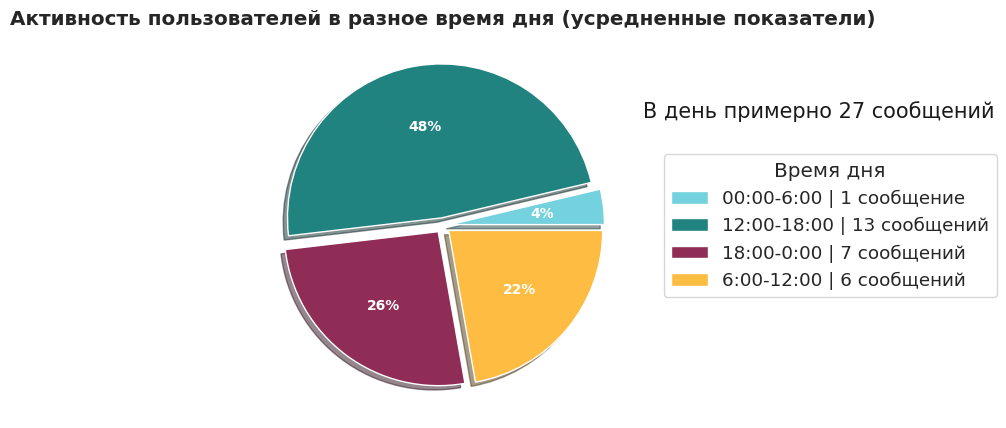

In [364]:
time_day_distribution.plot.pie(y='mean',explode=[0.05 for i in range(4)], autopct="%1.0f%%", shadow=True,
                      legend=False, ylabel="", labels=None,
                      textprops={'fontsize':10, 'color':'white', 'fontweight':'bold'})
plt.legend(labels=['00:00-6:00 | {} сообщение'.format(time_day_distribution.iloc[0]['mean']),
                   '12:00-18:00 | {} сообщений'.format(time_day_distribution.iloc[1]['mean']),
                   '18:00-0:00 | {} сообщений'.format(time_day_distribution.iloc[2]['mean']),
                   '6:00-12:00 | {} сообщений'.format(time_day_distribution.iloc[3]['mean'])], loc="center left",
           bbox_to_anchor=(1.05, 0, 0.5, 1), title='Время дня')
plt.text(1.3, 0.7,
         'В день примерно {} сообщений'.format(mean_day_activity),
         fontsize=15,
         color='k')
plt.title('Активность пользователей в разное время дня (усредненные показатели)', fontweight='bold')
plt.show()

## 3. Content analysis <a class="anchor" id="3"></a>

In [171]:
# How many files/photos?
print('Число отправленных фото/файлов:', whole_data.with_file.sum())

Число отправленных фото/файлов: 2695


In [172]:
# Distribution of different types of messages
message_data['type'].value_counts()

plain            44402
link              2229
cashtag            483
text_link          446
mention            435
email              365
bold               329
code               272
hashtag            253
bot_command        172
phone               47
italic              44
pre                 44
mention_name        14
spoiler              7
strikethrough        6
underline            5
custom_emoji         1
Name: type, dtype: int64

In [173]:
# most popular links
message_data[message_data.type=='link']['content'].value_counts().sort_values(ascending=False)[:7]

https://help.aimylogic.com/ru/article/integraciya-s-ifttt-sho8pe/                                                                           25
rawRequest.message.from.id                                                                                                                  18
https://help.aimylogic.com/ru/article/kak-validirovat-gorodskoj-nomer-telefona-i-otpravit-ego-v-telegram-s-pomoshyu-telegram-api-nea0jb/    14
https://help.aimylogic.com/ru/article/navyk-s-podderzhkoj-oplaty-6og7uf/                                                                    13
app.aimylogic.com                                                                                                                           11
https://help.aimylogic.com/ru/article/sistemnye-peremennye-g7hw80/                                                                          11
https://help.aimylogic.com/ru/article/chat-vidzhet-vgjc7a/                                                                                  10

In [174]:
# most popular hashtags
message_data[message_data.type=='hashtag']['content'].value_counts().sort_values(ascending=False)[:7]

#support          46
#help             29
#best_practice    18
#полезное         17
#урок             13
#idea             12
#question         11
Name: content, dtype: int64

In [175]:
# most popular emails
message_data[message_data.type=='email']['content'].value_counts().sort_values(ascending=False)[:7]

contact@aimylogic.com       57
partners@aimylogic.com      52
contact@just-ai.com         42
smmstudio@mediagramm.com    22
support@just-ai.com         16
client@just-ai.com          13
classics@inbox.ru            9
Name: content, dtype: int64

In [176]:
# who is the most mentioned?
message_data[message_data.type=='mention']['content'].value_counts().sort_values(ascending=False)[:7]

@ondreychikishev      48
@andreienz            28
@raytelegram          25
@raytgrm              23
@smplne               22
@MikhailBogolyubov    11
@huotis               11
Name: content, dtype: int64

## 4. Statistical analysis of text <a class="anchor" id="4"></a>

In [177]:
# for sentiment analysis we dont need special text, only human-readable 
text_only_data = message_data[message_data['type'].isin(['plain', 'strikethrough','underline',
                                                         'spoiler','italic','bold', "text_link"])]
text_only_data.shape

(45239, 2)

In [178]:
text_only_data.content = text_only_data.content.str.lower()
text_only_data['word_count'] =  text_only_data['content'].apply(lambda text: len(text.split()))
text_only_data.sample(5)

,type,content,word_count
7598,plain,спасибо большое,2
9565,plain,"спасибо, получилось. правильно ли понимаю, что...",36
2548,plain,как быть?,2
38763,plain,скорее всего галочка «звонить по местному врем...,7
34943,plain,"поняла, спасибо)\nбуду изучать",4


In [179]:
text_only_data.sort_values(by='word_count', ascending=False).head(7)

,type,content,word_count
13411,plain,.' does not contain a valid tag name.src/defau...,374
11187,plain,хочу высказать огромную благодарность сотрудни...,336
33794,plain,всем привет. принимайте новенького 😊\n\nв прод...,334
13419,plain,.' does not contain a valid tag name.src/defau...,298
35931,plain,уважаемые разработчики и коллеги бото-писатели...,292
27374,plain,"1)имеется ли у вас демо версия, может быть на ...",278
11927,plain,уважаемые наши пользователи! 🙂\n\nв ближайшее ...,274


In [180]:
text_only_data['word_count'].describe()

count    45239.000000
mean        12.014611
std         14.565883
min          0.000000
25%          3.000000
50%          8.000000
75%         15.000000
max        374.000000
Name: word_count, dtype: float64

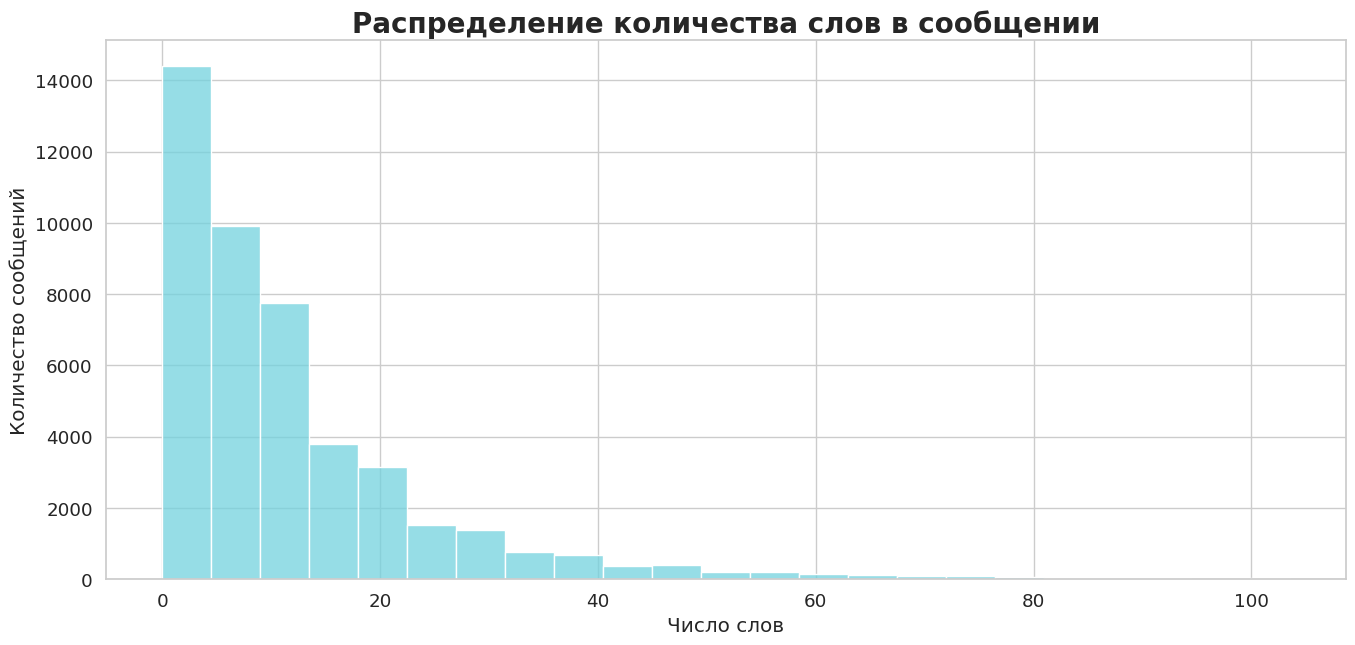

In [377]:
# distribution by number of words
plt.figure(figsize=(16, 7))
sns.histplot(data=text_only_data, x='word_count', binwidth=4.5, binrange=(0, 100))
plt.xlabel('Число слов')
plt.ylabel('Количество сообщений')
plt.title('Распределение количества слов в сообщении', fontweight='bold', fontsize=20)
plt.show()

In [368]:
def average_word(text):
    words = text.split()
    if len(words) > 0:
        return round(np.mean([len(w) for w in words]))
    else:
        return 0
text_only_data['average_word_length'] = text_only_data['content'].apply(average_word)
print('Средняя длина слова в сообщении - {} символов'.format(round(np.mean(text_only_data['average_word_length']))))
print('Медианное число слов в сообщении - {}'.format(int(text_only_data['word_count'].median())))

Средняя длина слова в сообщении - 5 символов
Медианное число слов в сообщении - 8


## 5. Frequency analysis <a class="anchor" id="5"></a>

In [369]:
spec_chars = string.punctuation + '\n\xa0«»\t`' + string.digits
russian_stop_words = stopwords.words('russian')

def delete_stop(sentence):
    tokens = word_tokenize(sentence)
    result = []
    for t in tokens:
        if (t in russian_stop_words) or (t in spec_chars):
            continue
        else:
            result.append(t)
    return ' '.join(result)

def delete_punct(sentence):
    result = []
    for c in sentence:
        if c in spec_chars:
            continue
        else:
            result.append(c)
    return ''.join(result)

# delete punctuation and stop-words
text_only_data['no_extra'] = text_only_data.content.apply(delete_stop)
text_only_data['no_extra'] = text_only_data['no_extra'].apply(delete_punct)
text_only_data['no_extra'] = text_only_data['no_extra'].apply(emoji.replace_emoji)
text_only_data.sample(5)

,type,content,word_count,average_word_length,no_extra
41621,plain,"добавьте на правый экран интент ""имена"", есть ...",8,6,добавьте правый экран интент имена встроенный
24462,plain,"спасибо! можете в чат написать, на какой стран...",12,5,спасибо можете чат написать странице расположе...
45463,plain,выставил все как здесь,4,5,выставил
47841,plain,"я написал в поддержку, может поправят. или мы ...",14,4,написал поддержку поправят глупые чтото делаем
1393,plain,"сценарий основным требованиям соответсвует, ту...",10,7,сценарий основным требованиям соответсвует смо...


In [370]:
words = word_tokenize(" ".join(text_only_data.no_extra.tolist()))
print(f'Число уникальных слов: {len(words)}')
tokens = Text(words)

Число уникальных слов: 333435


In [371]:
tokensFreq  = FreqDist(tokens)
tokensFreq.most_common(15)

[('это', 4331),
 ('спасибо', 2571),
 ('бота', 2283),
 ('бот', 2278),
 ('добрый', 1957),
 ('день', 1799),
 ('нужно', 1677),
 ('сделать', 1633),
 ('просто', 1462),
 ('работает', 1372),
 ('привет', 1319),
 ('вопрос', 1299),
 ('пожалуйста', 1256),
 ('можете', 1230),
 ('aimylogic', 1173)]

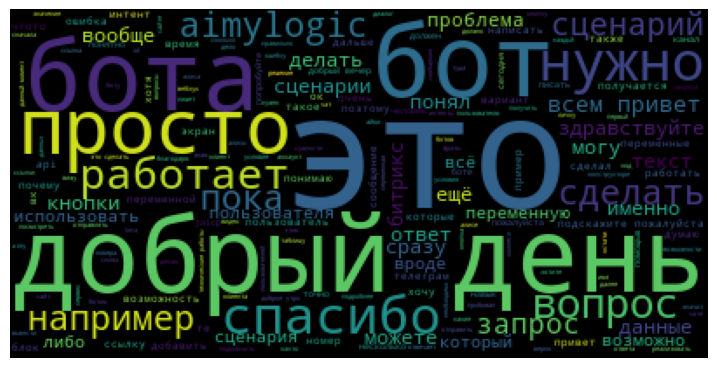

In [372]:
wordcloud_image = WordCloud().generate(text=" ".join(text_only_data.no_extra.tolist()))
plt.imshow(wordcloud_image)
plt.axis("off")
plt.show()